In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
df1 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Dislike_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Like_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['value diff'] = data_df['item_value_1'] - data_df['item_value_0']
kbins = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='uniform')
data_df['value diff'] = kbins.fit_transform(data_df[['value diff']])
mms = MinMaxScaler(feature_range=(-5, 5))
data_df['Right Value - Left Value'] = mms.fit_transform(data_df[['value diff']])

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.4)

obs_train = np.asarray(tr_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(ts_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(4357, 5) (2932, 5)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + 0.1**14), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 111       
                                                                 
Total params: 479 (1.87 KB)
Trainable params: 479 (1.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [10]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 2s 2s/step - loss: 36207.6680
Epoch 2/3500
1/1 [==============================] - 0s 10ms/step - loss: 36031.2070
Epoch 3/3500
1/1 [==============================] - 0s 10ms/step - loss: 35913.8203
Epoch 4/3500
1/1 [==============================] - 0s 10ms/step - loss: 35820.0039
Epoch 5/3500
1/1 [==============================] - 0s 7ms/step - loss: 35739.0625
Epoch 6/3500
1/1 [==============================] - 0s 6ms/step - loss: 35666.0195
Epoch 7/3500
1/1 [==============================] - 0s 7ms/step - loss: 35598.0156
Epoch 8/3500
1/1 [==============================] - 0s 7ms/step - loss: 35533.2109
Epoch 9/3500
1/1 [==============================] - 0s 8ms/step - loss: 35470.3477
Epoch 10/3500
1/1 [==============================] - 0s 7ms/step - loss: 35408.5586
Epoch 11/3500
1/1 [==============================] - 0s 6ms/step - loss: 35347.2578
Epoch 12/3500
1/1 [==============================] - 0s 7ms/step - loss: 35286.0703

1/1 [==============================] - 0s 10ms/step - loss: 30331.3438
Epoch 99/3500
1/1 [==============================] - 0s 11ms/step - loss: 30293.6426
Epoch 100/3500
1/1 [==============================] - 0s 9ms/step - loss: 30256.3672
Epoch 101/3500
1/1 [==============================] - 0s 11ms/step - loss: 30219.5137
Epoch 102/3500
1/1 [==============================] - 0s 9ms/step - loss: 30183.0762
Epoch 103/3500
1/1 [==============================] - 0s 9ms/step - loss: 30147.0469
Epoch 104/3500
1/1 [==============================] - 0s 10ms/step - loss: 30111.4258
Epoch 105/3500
1/1 [==============================] - 0s 11ms/step - loss: 30076.1953
Epoch 106/3500
1/1 [==============================] - 0s 9ms/step - loss: 30041.3594
Epoch 107/3500
1/1 [==============================] - 0s 10ms/step - loss: 30006.9102
Epoch 108/3500
1/1 [==============================] - 0s 11ms/step - loss: 29972.8359
Epoch 109/3500
1/1 [==============================] - 0s 10ms/step - loss:

Epoch 194/3500
1/1 [==============================] - 0s 10ms/step - loss: 27954.5195
Epoch 195/3500
1/1 [==============================] - 0s 10ms/step - loss: 27937.6172
Epoch 196/3500
1/1 [==============================] - 0s 8ms/step - loss: 27920.8047
Epoch 197/3500
1/1 [==============================] - 0s 8ms/step - loss: 27904.0781
Epoch 198/3500
1/1 [==============================] - 0s 8ms/step - loss: 27887.4453
Epoch 199/3500
1/1 [==============================] - 0s 7ms/step - loss: 27870.9004
Epoch 200/3500
1/1 [==============================] - 0s 8ms/step - loss: 27854.4375
Epoch 201/3500
1/1 [==============================] - 0s 8ms/step - loss: 27838.0586
Epoch 202/3500
1/1 [==============================] - 0s 7ms/step - loss: 27821.7695
Epoch 203/3500
1/1 [==============================] - 0s 8ms/step - loss: 27805.5547
Epoch 204/3500
1/1 [==============================] - 0s 8ms/step - loss: 27789.4258
Epoch 205/3500
1/1 [==============================] - 0s 8ms/st

1/1 [==============================] - 0s 7ms/step - loss: 26618.9609
Epoch 291/3500
1/1 [==============================] - 0s 8ms/step - loss: 26607.1465
Epoch 292/3500
1/1 [==============================] - 0s 7ms/step - loss: 26595.3633
Epoch 293/3500
1/1 [==============================] - 0s 7ms/step - loss: 26583.6094
Epoch 294/3500
1/1 [==============================] - 0s 7ms/step - loss: 26571.8848
Epoch 295/3500
1/1 [==============================] - 0s 7ms/step - loss: 26560.1875
Epoch 296/3500
1/1 [==============================] - 0s 7ms/step - loss: 26548.5195
Epoch 297/3500
1/1 [==============================] - 0s 7ms/step - loss: 26536.8828
Epoch 298/3500
1/1 [==============================] - 0s 7ms/step - loss: 26525.2715
Epoch 299/3500
1/1 [==============================] - 0s 9ms/step - loss: 26513.6855
Epoch 300/3500
1/1 [==============================] - 0s 9ms/step - loss: 26502.1328
Epoch 301/3500
1/1 [==============================] - 0s 12ms/step - loss: 26490

1/1 [==============================] - 0s 10ms/step - loss: 25590.9395
Epoch 387/3500
1/1 [==============================] - 0s 10ms/step - loss: 25581.1309
Epoch 388/3500
1/1 [==============================] - 0s 9ms/step - loss: 25571.3340
Epoch 389/3500
1/1 [==============================] - 0s 8ms/step - loss: 25561.5508
Epoch 390/3500
1/1 [==============================] - 0s 7ms/step - loss: 25551.7852
Epoch 391/3500
1/1 [==============================] - 0s 7ms/step - loss: 25542.0352
Epoch 392/3500
1/1 [==============================] - 0s 7ms/step - loss: 25532.2969
Epoch 393/3500
1/1 [==============================] - 0s 7ms/step - loss: 25522.5742
Epoch 394/3500
1/1 [==============================] - 0s 7ms/step - loss: 25512.8652
Epoch 395/3500
1/1 [==============================] - 0s 7ms/step - loss: 25503.1758
Epoch 396/3500
1/1 [==============================] - 0s 7ms/step - loss: 25493.4961
Epoch 397/3500
1/1 [==============================] - 0s 7ms/step - loss: 2548

1/1 [==============================] - 0s 10ms/step - loss: 24709.7793
Epoch 483/3500
1/1 [==============================] - 0s 10ms/step - loss: 24701.1797
Epoch 484/3500
1/1 [==============================] - 0s 10ms/step - loss: 24692.5938
Epoch 485/3500
1/1 [==============================] - 0s 9ms/step - loss: 24684.0195
Epoch 486/3500
1/1 [==============================] - 0s 10ms/step - loss: 24675.4492
Epoch 487/3500
1/1 [==============================] - 0s 9ms/step - loss: 24666.8867
Epoch 488/3500
1/1 [==============================] - 0s 9ms/step - loss: 24658.3262
Epoch 489/3500
1/1 [==============================] - 0s 9ms/step - loss: 24649.7656
Epoch 490/3500
1/1 [==============================] - 0s 9ms/step - loss: 24641.1777
Epoch 491/3500
1/1 [==============================] - 0s 9ms/step - loss: 24632.5898
Epoch 492/3500
1/1 [==============================] - 0s 9ms/step - loss: 24624.0195
Epoch 493/3500
1/1 [==============================] - 0s 9ms/step - loss: 24

1/1 [==============================] - 0s 7ms/step - loss: 23918.7754
Epoch 579/3500
1/1 [==============================] - 0s 7ms/step - loss: 23910.7812
Epoch 580/3500
1/1 [==============================] - 0s 7ms/step - loss: 23902.8633
Epoch 581/3500
1/1 [==============================] - 0s 7ms/step - loss: 23894.8750
Epoch 582/3500
1/1 [==============================] - 0s 7ms/step - loss: 23886.9609
Epoch 583/3500
1/1 [==============================] - 0s 7ms/step - loss: 23878.9785
Epoch 584/3500
1/1 [==============================] - 0s 7ms/step - loss: 23871.0703
Epoch 585/3500
1/1 [==============================] - 0s 7ms/step - loss: 23863.0938
Epoch 586/3500
1/1 [==============================] - 0s 7ms/step - loss: 23855.1895
Epoch 587/3500
1/1 [==============================] - 0s 7ms/step - loss: 23847.2148
Epoch 588/3500
1/1 [==============================] - 0s 7ms/step - loss: 23839.3125
Epoch 589/3500
1/1 [==============================] - 0s 7ms/step - loss: 23831.

1/1 [==============================] - 0s 18ms/step - loss: 23042.4180
Epoch 675/3500
1/1 [==============================] - 0s 15ms/step - loss: 23032.7695
Epoch 676/3500
1/1 [==============================] - 0s 16ms/step - loss: 23023.3047
Epoch 677/3500
1/1 [==============================] - 0s 15ms/step - loss: 23013.6562
Epoch 678/3500
1/1 [==============================] - 0s 16ms/step - loss: 23004.1875
Epoch 679/3500
1/1 [==============================] - 0s 16ms/step - loss: 22994.5391
Epoch 680/3500
1/1 [==============================] - 0s 8ms/step - loss: 22985.0664
Epoch 681/3500
1/1 [==============================] - 0s 8ms/step - loss: 22975.4180
Epoch 682/3500
1/1 [==============================] - 0s 8ms/step - loss: 22965.9453
Epoch 683/3500
1/1 [==============================] - 0s 8ms/step - loss: 22956.2930
Epoch 684/3500
1/1 [==============================] - 0s 8ms/step - loss: 22946.8203
Epoch 685/3500
1/1 [==============================] - 0s 8ms/step - loss: 

1/1 [==============================] - 0s 8ms/step - loss: 22007.5312
Epoch 771/3500
1/1 [==============================] - 0s 9ms/step - loss: 21997.1914
Epoch 772/3500
1/1 [==============================] - 0s 8ms/step - loss: 21987.3672
Epoch 773/3500
1/1 [==============================] - 0s 10ms/step - loss: 21977.1836
Epoch 774/3500
1/1 [==============================] - 0s 9ms/step - loss: 21967.5020
Epoch 775/3500
1/1 [==============================] - 0s 9ms/step - loss: 21957.4609
Epoch 776/3500
1/1 [==============================] - 0s 9ms/step - loss: 21947.9160
Epoch 777/3500
1/1 [==============================] - 0s 9ms/step - loss: 21938.0098
Epoch 778/3500
1/1 [==============================] - 0s 8ms/step - loss: 21928.5938
Epoch 779/3500
1/1 [==============================] - 0s 8ms/step - loss: 21918.8164
Epoch 780/3500
1/1 [==============================] - 0s 8ms/step - loss: 21909.5195
Epoch 781/3500
1/1 [==============================] - 0s 9ms/step - loss: 21899

1/1 [==============================] - 0s 9ms/step - loss: 21219.8477
Epoch 867/3500
1/1 [==============================] - 0s 11ms/step - loss: 21212.6445
Epoch 868/3500
1/1 [==============================] - 0s 10ms/step - loss: 21205.7031
Epoch 869/3500
1/1 [==============================] - 0s 8ms/step - loss: 21198.5273
Epoch 870/3500
1/1 [==============================] - 0s 8ms/step - loss: 21191.6035
Epoch 871/3500
1/1 [==============================] - 0s 8ms/step - loss: 21184.4531
Epoch 872/3500
1/1 [==============================] - 0s 12ms/step - loss: 21177.5547
Epoch 873/3500
1/1 [==============================] - 0s 12ms/step - loss: 21170.4297
Epoch 874/3500
1/1 [==============================] - 0s 16ms/step - loss: 21163.5469
Epoch 875/3500
1/1 [==============================] - 0s 12ms/step - loss: 21156.4492
Epoch 876/3500
1/1 [==============================] - 0s 17ms/step - loss: 21149.5879
Epoch 877/3500
1/1 [==============================] - 0s 13ms/step - loss

1/1 [==============================] - 0s 8ms/step - loss: 20575.0977
Epoch 962/3500
1/1 [==============================] - 0s 9ms/step - loss: 20567.9102
Epoch 963/3500
1/1 [==============================] - 0s 9ms/step - loss: 20560.7207
Epoch 964/3500
1/1 [==============================] - 0s 8ms/step - loss: 20553.4844
Epoch 965/3500
1/1 [==============================] - 0s 9ms/step - loss: 20546.2188
Epoch 966/3500
1/1 [==============================] - 0s 8ms/step - loss: 20538.9141
Epoch 967/3500
1/1 [==============================] - 0s 9ms/step - loss: 20531.5742
Epoch 968/3500
1/1 [==============================] - 0s 9ms/step - loss: 20524.2148
Epoch 969/3500
1/1 [==============================] - 0s 8ms/step - loss: 20516.8047
Epoch 970/3500
1/1 [==============================] - 0s 9ms/step - loss: 20509.3164
Epoch 971/3500
1/1 [==============================] - 0s 17ms/step - loss: 20501.6074
Epoch 972/3500
1/1 [==============================] - 0s 15ms/step - loss: 2049

1/1 [==============================] - 0s 10ms/step - loss: 19620.1641
Epoch 1057/3500
1/1 [==============================] - 0s 9ms/step - loss: 19610.6992
Epoch 1058/3500
1/1 [==============================] - 0s 7ms/step - loss: 19601.2617
Epoch 1059/3500
1/1 [==============================] - 0s 10ms/step - loss: 19591.8809
Epoch 1060/3500
1/1 [==============================] - 0s 9ms/step - loss: 19582.5215
Epoch 1061/3500
1/1 [==============================] - 0s 8ms/step - loss: 19573.2148
Epoch 1062/3500
1/1 [==============================] - 0s 11ms/step - loss: 19563.9297
Epoch 1063/3500
1/1 [==============================] - 0s 9ms/step - loss: 19554.6953
Epoch 1064/3500
1/1 [==============================] - 0s 9ms/step - loss: 19545.4766
Epoch 1065/3500
1/1 [==============================] - 0s 10ms/step - loss: 19536.3066
Epoch 1066/3500
1/1 [==============================] - 0s 9ms/step - loss: 19527.1504
Epoch 1067/3500
1/1 [==============================] - 0s 9ms/step

1/1 [==============================] - 0s 7ms/step - loss: 18830.3477
Epoch 1151/3500
1/1 [==============================] - 0s 7ms/step - loss: 18822.8047
Epoch 1152/3500
1/1 [==============================] - 0s 8ms/step - loss: 18815.2305
Epoch 1153/3500
1/1 [==============================] - 0s 7ms/step - loss: 18807.7773
Epoch 1154/3500
1/1 [==============================] - 0s 8ms/step - loss: 18800.2891
Epoch 1155/3500
1/1 [==============================] - 0s 8ms/step - loss: 18792.9277
Epoch 1156/3500
1/1 [==============================] - 0s 8ms/step - loss: 18785.5254
Epoch 1157/3500
1/1 [==============================] - 0s 8ms/step - loss: 18778.2461
Epoch 1158/3500
1/1 [==============================] - 0s 7ms/step - loss: 18770.9258
Epoch 1159/3500
1/1 [==============================] - 0s 9ms/step - loss: 18763.7266
Epoch 1160/3500
1/1 [==============================] - 0s 12ms/step - loss: 18756.4844
Epoch 1161/3500
1/1 [==============================] - 0s 14ms/step -

1/1 [==============================] - 0s 7ms/step - loss: 18251.0664
Epoch 1245/3500
1/1 [==============================] - 0s 8ms/step - loss: 18245.9609
Epoch 1246/3500
1/1 [==============================] - 0s 7ms/step - loss: 18240.7090
Epoch 1247/3500
1/1 [==============================] - 0s 9ms/step - loss: 18235.5645
Epoch 1248/3500
1/1 [==============================] - 0s 8ms/step - loss: 18230.3359
Epoch 1249/3500
1/1 [==============================] - 0s 8ms/step - loss: 18225.2422
Epoch 1250/3500
1/1 [==============================] - 0s 8ms/step - loss: 18220.1113
Epoch 1251/3500
1/1 [==============================] - 0s 10ms/step - loss: 18215.0859
Epoch 1252/3500
1/1 [==============================] - 0s 10ms/step - loss: 18210.0234
Epoch 1253/3500
1/1 [==============================] - 0s 12ms/step - loss: 18205.0312
Epoch 1254/3500
1/1 [==============================] - 0s 12ms/step - loss: 18199.9727
Epoch 1255/3500
1/1 [==============================] - 0s 10ms/ste

1/1 [==============================] - 0s 17ms/step - loss: 17823.1289
Epoch 1340/3500
1/1 [==============================] - 0s 22ms/step - loss: 17819.2500
Epoch 1341/3500
1/1 [==============================] - 0s 22ms/step - loss: 17815.4766
Epoch 1342/3500
1/1 [==============================] - 0s 26ms/step - loss: 17811.6523
Epoch 1343/3500
1/1 [==============================] - 0s 19ms/step - loss: 17807.8691
Epoch 1344/3500
1/1 [==============================] - 0s 13ms/step - loss: 17804.0195
Epoch 1345/3500
1/1 [==============================] - 0s 8ms/step - loss: 17800.1855
Epoch 1346/3500
1/1 [==============================] - 0s 8ms/step - loss: 17796.3203
Epoch 1347/3500
1/1 [==============================] - 0s 8ms/step - loss: 17792.5117
Epoch 1348/3500
1/1 [==============================] - 0s 8ms/step - loss: 17788.6875
Epoch 1349/3500
1/1 [==============================] - 0s 7ms/step - loss: 17784.9805
Epoch 1350/3500
1/1 [==============================] - 0s 8ms/st

1/1 [==============================] - 0s 9ms/step - loss: 17503.5508
Epoch 1435/3500
1/1 [==============================] - 0s 9ms/step - loss: 17500.7637
Epoch 1436/3500
1/1 [==============================] - 0s 8ms/step - loss: 17497.9961
Epoch 1437/3500
1/1 [==============================] - 0s 15ms/step - loss: 17495.2656
Epoch 1438/3500
1/1 [==============================] - 0s 17ms/step - loss: 17492.3848
Epoch 1439/3500
1/1 [==============================] - 0s 15ms/step - loss: 17489.4922
Epoch 1440/3500
1/1 [==============================] - 0s 19ms/step - loss: 17486.4805
Epoch 1441/3500
1/1 [==============================] - 0s 16ms/step - loss: 17483.5938
Epoch 1442/3500
1/1 [==============================] - 0s 18ms/step - loss: 17480.7656
Epoch 1443/3500
1/1 [==============================] - 0s 12ms/step - loss: 17478.0586
Epoch 1444/3500
1/1 [==============================] - 0s 21ms/step - loss: 17475.3516
Epoch 1445/3500
1/1 [==============================] - 0s 19ms

1/1 [==============================] - 0s 10ms/step - loss: 17267.5547
Epoch 1529/3500
1/1 [==============================] - 0s 9ms/step - loss: 17265.5664
Epoch 1530/3500
1/1 [==============================] - 0s 11ms/step - loss: 17263.5547
Epoch 1531/3500
1/1 [==============================] - 0s 13ms/step - loss: 17261.4297
Epoch 1532/3500
1/1 [==============================] - 0s 9ms/step - loss: 17259.1191
Epoch 1533/3500
1/1 [==============================] - 0s 9ms/step - loss: 17256.7227
Epoch 1534/3500
1/1 [==============================] - 0s 10ms/step - loss: 17254.3711
Epoch 1535/3500
1/1 [==============================] - 0s 9ms/step - loss: 17252.1250
Epoch 1536/3500
1/1 [==============================] - 0s 8ms/step - loss: 17249.9336
Epoch 1537/3500
1/1 [==============================] - 0s 9ms/step - loss: 17247.9180
Epoch 1538/3500
1/1 [==============================] - 0s 9ms/step - loss: 17245.8379
Epoch 1539/3500
1/1 [==============================] - 0s 10ms/ste

Epoch 1623/3500
1/1 [==============================] - 0s 8ms/step - loss: 17075.9766
Epoch 1624/3500
1/1 [==============================] - 0s 8ms/step - loss: 17074.1152
Epoch 1625/3500
1/1 [==============================] - 0s 8ms/step - loss: 17072.2617
Epoch 1626/3500
1/1 [==============================] - 0s 10ms/step - loss: 17070.2012
Epoch 1627/3500
1/1 [==============================] - 0s 9ms/step - loss: 17068.2070
Epoch 1628/3500
1/1 [==============================] - 0s 10ms/step - loss: 17066.2402
Epoch 1629/3500
1/1 [==============================] - 0s 9ms/step - loss: 17064.4375
Epoch 1630/3500
1/1 [==============================] - 0s 9ms/step - loss: 17062.7715
Epoch 1631/3500
1/1 [==============================] - 0s 9ms/step - loss: 17061.2109
Epoch 1632/3500
1/1 [==============================] - 0s 8ms/step - loss: 17059.5410
Epoch 1633/3500
1/1 [==============================] - 0s 9ms/step - loss: 17057.6484
Epoch 1634/3500
1/1 [==============================]

1/1 [==============================] - 0s 13ms/step - loss: 16914.8672
Epoch 1718/3500
1/1 [==============================] - 0s 14ms/step - loss: 16912.9961
Epoch 1719/3500
1/1 [==============================] - 0s 28ms/step - loss: 16911.0039
Epoch 1720/3500
1/1 [==============================] - 0s 13ms/step - loss: 16909.0977
Epoch 1721/3500
1/1 [==============================] - 0s 12ms/step - loss: 16907.4453
Epoch 1722/3500
1/1 [==============================] - 0s 9ms/step - loss: 16905.9492
Epoch 1723/3500
1/1 [==============================] - 0s 11ms/step - loss: 16904.6934
Epoch 1724/3500
1/1 [==============================] - 0s 12ms/step - loss: 16903.4141
Epoch 1725/3500
1/1 [==============================] - 0s 11ms/step - loss: 16902.1055
Epoch 1726/3500
1/1 [==============================] - 0s 11ms/step - loss: 16900.4180
Epoch 1727/3500
1/1 [==============================] - 0s 14ms/step - loss: 16898.6094
Epoch 1728/3500
1/1 [==============================] - 0s 12

1/1 [==============================] - 0s 9ms/step - loss: 16776.5859
Epoch 1812/3500
1/1 [==============================] - 0s 8ms/step - loss: 16774.7812
Epoch 1813/3500
1/1 [==============================] - 0s 8ms/step - loss: 16773.0508
Epoch 1814/3500
1/1 [==============================] - 0s 8ms/step - loss: 16771.4258
Epoch 1815/3500
1/1 [==============================] - 0s 9ms/step - loss: 16770.1016
Epoch 1816/3500
1/1 [==============================] - 0s 10ms/step - loss: 16769.0234
Epoch 1817/3500
1/1 [==============================] - 0s 12ms/step - loss: 16768.2695
Epoch 1818/3500
1/1 [==============================] - 0s 9ms/step - loss: 16767.4355
Epoch 1819/3500
1/1 [==============================] - 0s 8ms/step - loss: 16766.0938
Epoch 1820/3500
1/1 [==============================] - 0s 9ms/step - loss: 16764.3184
Epoch 1821/3500
1/1 [==============================] - 0s 27ms/step - loss: 16762.4609
Epoch 1822/3500
1/1 [==============================] - 0s 39ms/step

1/1 [==============================] - 0s 8ms/step - loss: 16659.6328
Epoch 1906/3500
1/1 [==============================] - 0s 9ms/step - loss: 16657.8867
Epoch 1907/3500
1/1 [==============================] - 0s 11ms/step - loss: 16656.2500
Epoch 1908/3500
1/1 [==============================] - 0s 8ms/step - loss: 16654.8184
Epoch 1909/3500
1/1 [==============================] - 0s 9ms/step - loss: 16653.7207
Epoch 1910/3500
1/1 [==============================] - 0s 8ms/step - loss: 16652.8379
Epoch 1911/3500
1/1 [==============================] - 0s 9ms/step - loss: 16652.2617
Epoch 1912/3500
1/1 [==============================] - 0s 8ms/step - loss: 16651.6055
Epoch 1913/3500
1/1 [==============================] - 0s 9ms/step - loss: 16650.7070
Epoch 1914/3500
1/1 [==============================] - 0s 10ms/step - loss: 16649.1875
Epoch 1915/3500
1/1 [==============================] - 0s 10ms/step - loss: 16647.5762
Epoch 1916/3500
1/1 [==============================] - 0s 9ms/step 

1/1 [==============================] - 0s 57ms/step - loss: 16559.4492
Epoch 2001/3500
1/1 [==============================] - 0s 11ms/step - loss: 16558.3730
Epoch 2002/3500
1/1 [==============================] - 0s 9ms/step - loss: 16556.7500
Epoch 2003/3500
1/1 [==============================] - 0s 10ms/step - loss: 16555.2695
Epoch 2004/3500
1/1 [==============================] - 0s 9ms/step - loss: 16553.8906
Epoch 2005/3500
1/1 [==============================] - 0s 10ms/step - loss: 16552.8711
Epoch 2006/3500
1/1 [==============================] - 0s 9ms/step - loss: 16552.1523
Epoch 2007/3500
1/1 [==============================] - 0s 11ms/step - loss: 16551.9414
Epoch 2008/3500
1/1 [==============================] - 0s 9ms/step - loss: 16551.8613
Epoch 2009/3500
1/1 [==============================] - 0s 8ms/step - loss: 16551.1328
Epoch 2010/3500
1/1 [==============================] - 0s 9ms/step - loss: 16549.6875
Epoch 2011/3500
1/1 [==============================] - 0s 9ms/ste

1/1 [==============================] - 0s 10ms/step - loss: 16468.7695
Epoch 2096/3500
1/1 [==============================] - 0s 8ms/step - loss: 16468.7832
Epoch 2097/3500
1/1 [==============================] - 0s 9ms/step - loss: 16468.8555
Epoch 2098/3500
1/1 [==============================] - 0s 8ms/step - loss: 16468.1074
Epoch 2099/3500
1/1 [==============================] - 0s 8ms/step - loss: 16466.4727
Epoch 2100/3500
1/1 [==============================] - 0s 17ms/step - loss: 16464.7656
Epoch 2101/3500
1/1 [==============================] - 0s 12ms/step - loss: 16463.3516
Epoch 2102/3500
1/1 [==============================] - 0s 10ms/step - loss: 16462.1562
Epoch 2103/3500
1/1 [==============================] - 0s 10ms/step - loss: 16461.4102
Epoch 2104/3500
1/1 [==============================] - 0s 12ms/step - loss: 16460.8828
Epoch 2105/3500
1/1 [==============================] - 0s 11ms/step - loss: 16460.6641
Epoch 2106/3500
1/1 [==============================] - 0s 11ms/

1/1 [==============================] - 0s 9ms/step - loss: 16387.1543
Epoch 2191/3500
1/1 [==============================] - 0s 9ms/step - loss: 16385.7344
Epoch 2192/3500
1/1 [==============================] - 0s 8ms/step - loss: 16384.6113
Epoch 2193/3500
1/1 [==============================] - 0s 9ms/step - loss: 16383.8789
Epoch 2194/3500
1/1 [==============================] - 0s 14ms/step - loss: 16383.3789
Epoch 2195/3500
1/1 [==============================] - 0s 22ms/step - loss: 16383.2725
Epoch 2196/3500
1/1 [==============================] - 0s 19ms/step - loss: 16382.9863
Epoch 2197/3500
1/1 [==============================] - 0s 42ms/step - loss: 16382.3730
Epoch 2198/3500
1/1 [==============================] - 0s 18ms/step - loss: 16381.0381
Epoch 2199/3500
1/1 [==============================] - 0s 9ms/step - loss: 16379.5918
Epoch 2200/3500
1/1 [==============================] - 0s 8ms/step - loss: 16378.3027
Epoch 2201/3500
1/1 [==============================] - 0s 8ms/ste

1/1 [==============================] - 0s 22ms/step - loss: 16314.4932
Epoch 2286/3500
1/1 [==============================] - 0s 17ms/step - loss: 16314.0605
Epoch 2287/3500
1/1 [==============================] - 0s 19ms/step - loss: 16313.8467
Epoch 2288/3500
1/1 [==============================] - 0s 17ms/step - loss: 16313.4707
Epoch 2289/3500
1/1 [==============================] - 0s 21ms/step - loss: 16313.2617
Epoch 2290/3500
1/1 [==============================] - 0s 20ms/step - loss: 16312.3193
Epoch 2291/3500
1/1 [==============================] - 0s 18ms/step - loss: 16311.3955
Epoch 2292/3500
1/1 [==============================] - 0s 19ms/step - loss: 16310.2061
Epoch 2293/3500
1/1 [==============================] - 0s 22ms/step - loss: 16309.0166
Epoch 2294/3500
1/1 [==============================] - 0s 42ms/step - loss: 16308.1367
Epoch 2295/3500
1/1 [==============================] - 0s 10ms/step - loss: 16307.2920
Epoch 2296/3500
1/1 [==============================] - 0s 9

1/1 [==============================] - 0s 9ms/step - loss: 16255.8643
Epoch 2380/3500
1/1 [==============================] - 0s 8ms/step - loss: 16258.0898
Epoch 2381/3500
1/1 [==============================] - 0s 8ms/step - loss: 16258.7725
Epoch 2382/3500
1/1 [==============================] - 0s 8ms/step - loss: 16256.5273
Epoch 2383/3500
1/1 [==============================] - 0s 10ms/step - loss: 16254.0020
Epoch 2384/3500
1/1 [==============================] - 0s 7ms/step - loss: 16252.2266
Epoch 2385/3500
1/1 [==============================] - 0s 8ms/step - loss: 16251.2666
Epoch 2386/3500
1/1 [==============================] - 0s 8ms/step - loss: 16250.2900
Epoch 2387/3500
1/1 [==============================] - 0s 8ms/step - loss: 16250.1338
Epoch 2388/3500
1/1 [==============================] - 0s 10ms/step - loss: 16249.5146
Epoch 2389/3500
1/1 [==============================] - 0s 7ms/step - loss: 16249.6943
Epoch 2390/3500
1/1 [==============================] - 0s 8ms/step -

1/1 [==============================] - 0s 15ms/step - loss: 16202.6748
Epoch 2474/3500
1/1 [==============================] - 0s 21ms/step - loss: 16202.2549
Epoch 2475/3500
1/1 [==============================] - 0s 14ms/step - loss: 16202.0254
Epoch 2476/3500
1/1 [==============================] - 0s 12ms/step - loss: 16201.9688
Epoch 2477/3500
1/1 [==============================] - 0s 11ms/step - loss: 16202.4199
Epoch 2478/3500
1/1 [==============================] - 0s 11ms/step - loss: 16202.4912
Epoch 2479/3500
1/1 [==============================] - 0s 11ms/step - loss: 16203.4902
Epoch 2480/3500
1/1 [==============================] - 0s 9ms/step - loss: 16201.2285
Epoch 2481/3500
1/1 [==============================] - 0s 8ms/step - loss: 16200.0537
Epoch 2482/3500
1/1 [==============================] - 0s 9ms/step - loss: 16198.3125
Epoch 2483/3500
1/1 [==============================] - 0s 9ms/step - loss: 16197.7119
Epoch 2484/3500
1/1 [==============================] - 0s 12ms/

1/1 [==============================] - 0s 9ms/step - loss: 16157.2344
Epoch 2568/3500
1/1 [==============================] - 0s 7ms/step - loss: 16156.0176
Epoch 2569/3500
1/1 [==============================] - 0s 8ms/step - loss: 16155.3691
Epoch 2570/3500
1/1 [==============================] - 0s 7ms/step - loss: 16155.2881
Epoch 2571/3500
1/1 [==============================] - 0s 9ms/step - loss: 16155.3232
Epoch 2572/3500
1/1 [==============================] - 0s 8ms/step - loss: 16155.6631
Epoch 2573/3500
1/1 [==============================] - 0s 7ms/step - loss: 16154.3174
Epoch 2574/3500
1/1 [==============================] - 0s 11ms/step - loss: 16154.8076
Epoch 2575/3500
1/1 [==============================] - 0s 7ms/step - loss: 16155.1455
Epoch 2576/3500
1/1 [==============================] - 0s 8ms/step - loss: 16156.7129
Epoch 2577/3500
1/1 [==============================] - 0s 10ms/step - loss: 16155.4258
Epoch 2578/3500
1/1 [==============================] - 0s 9ms/step -

1/1 [==============================] - 0s 7ms/step - loss: 16117.3408
Epoch 2663/3500
1/1 [==============================] - 0s 7ms/step - loss: 16116.3535
Epoch 2664/3500
1/1 [==============================] - 0s 7ms/step - loss: 16115.2539
Epoch 2665/3500
1/1 [==============================] - 0s 7ms/step - loss: 16114.5264
Epoch 2666/3500
1/1 [==============================] - 0s 7ms/step - loss: 16114.7324
Epoch 2667/3500
1/1 [==============================] - 0s 7ms/step - loss: 16113.3916
Epoch 2668/3500
1/1 [==============================] - 0s 7ms/step - loss: 16114.8623
Epoch 2669/3500
1/1 [==============================] - 0s 7ms/step - loss: 16116.8604
Epoch 2670/3500
1/1 [==============================] - 0s 7ms/step - loss: 16118.4395
Epoch 2671/3500
1/1 [==============================] - 0s 7ms/step - loss: 16118.1895
Epoch 2672/3500
1/1 [==============================] - 0s 7ms/step - loss: 16115.8740
Epoch 2673/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 16085.3906
Epoch 2758/3500
1/1 [==============================] - 0s 9ms/step - loss: 16086.7041
Epoch 2759/3500
1/1 [==============================] - 0s 10ms/step - loss: 16084.2324
Epoch 2760/3500
1/1 [==============================] - 0s 8ms/step - loss: 16083.0205
Epoch 2761/3500
1/1 [==============================] - 0s 8ms/step - loss: 16081.3916
Epoch 2762/3500
1/1 [==============================] - 0s 8ms/step - loss: 16080.1875
Epoch 2763/3500
1/1 [==============================] - 0s 8ms/step - loss: 16079.1514
Epoch 2764/3500
1/1 [==============================] - 0s 8ms/step - loss: 16078.4902
Epoch 2765/3500
1/1 [==============================] - 0s 8ms/step - loss: 16077.6807
Epoch 2766/3500
1/1 [==============================] - 0s 8ms/step - loss: 16077.4180
Epoch 2767/3500
1/1 [==============================] - 0s 8ms/step - loss: 16076.5264
Epoch 2768/3500
1/1 [==============================] - 0s 9ms/step - 

1/1 [==============================] - 0s 9ms/step - loss: 16051.9658
Epoch 2853/3500
1/1 [==============================] - 0s 9ms/step - loss: 16051.5752
Epoch 2854/3500
1/1 [==============================] - 0s 9ms/step - loss: 16051.9805
Epoch 2855/3500
1/1 [==============================] - 0s 8ms/step - loss: 16050.8574
Epoch 2856/3500
1/1 [==============================] - 0s 8ms/step - loss: 16049.9834
Epoch 2857/3500
1/1 [==============================] - 0s 7ms/step - loss: 16049.1699
Epoch 2858/3500
1/1 [==============================] - 0s 7ms/step - loss: 16048.8799
Epoch 2859/3500
1/1 [==============================] - 0s 7ms/step - loss: 16048.6191
Epoch 2860/3500
1/1 [==============================] - 0s 7ms/step - loss: 16048.8008
Epoch 2861/3500
1/1 [==============================] - 0s 7ms/step - loss: 16049.2539
Epoch 2862/3500
1/1 [==============================] - 0s 7ms/step - loss: 16050.6367
Epoch 2863/3500
1/1 [==============================] - 0s 7ms/step - l

Epoch 2947/3500
1/1 [==============================] - 0s 10ms/step - loss: 16023.3701
Epoch 2948/3500
1/1 [==============================] - 0s 9ms/step - loss: 16022.9404
Epoch 2949/3500
1/1 [==============================] - 0s 9ms/step - loss: 16028.2676
Epoch 2950/3500
1/1 [==============================] - 0s 10ms/step - loss: 16049.8252
Epoch 2951/3500
1/1 [==============================] - 0s 10ms/step - loss: 16024.7529
Epoch 2952/3500
1/1 [==============================] - 0s 10ms/step - loss: 16021.8018
Epoch 2953/3500
1/1 [==============================] - 0s 10ms/step - loss: 16019.4756
Epoch 2954/3500
1/1 [==============================] - 0s 9ms/step - loss: 16018.3672
Epoch 2955/3500
1/1 [==============================] - 0s 10ms/step - loss: 16018.7139
Epoch 2956/3500
1/1 [==============================] - 0s 9ms/step - loss: 16017.9756
Epoch 2957/3500
1/1 [==============================] - 0s 9ms/step - loss: 16017.6895
Epoch 2958/3500
1/1 [===========================

1/1 [==============================] - 0s 8ms/step - loss: 16000.5986
Epoch 3043/3500
1/1 [==============================] - 0s 8ms/step - loss: 16000.9785
Epoch 3044/3500
1/1 [==============================] - 0s 8ms/step - loss: 16001.1992
Epoch 3045/3500
1/1 [==============================] - 0s 8ms/step - loss: 16001.9795
Epoch 3046/3500
1/1 [==============================] - 0s 8ms/step - loss: 16001.4688
Epoch 3047/3500
1/1 [==============================] - 0s 8ms/step - loss: 16000.9014
Epoch 3048/3500
1/1 [==============================] - 0s 8ms/step - loss: 15999.4199
Epoch 3049/3500
1/1 [==============================] - 0s 8ms/step - loss: 15998.9658
Epoch 3050/3500
1/1 [==============================] - 0s 7ms/step - loss: 15997.5068
Epoch 3051/3500
1/1 [==============================] - 0s 7ms/step - loss: 15996.7998
Epoch 3052/3500
1/1 [==============================] - 0s 8ms/step - loss: 15997.5928
Epoch 3053/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 15ms/step - loss: 15978.9854
Epoch 3137/3500
1/1 [==============================] - 0s 16ms/step - loss: 15979.7568
Epoch 3138/3500
1/1 [==============================] - 0s 16ms/step - loss: 15983.4844
Epoch 3139/3500
1/1 [==============================] - 0s 18ms/step - loss: 15988.3076
Epoch 3140/3500
1/1 [==============================] - 0s 15ms/step - loss: 15981.7725
Epoch 3141/3500
1/1 [==============================] - 0s 9ms/step - loss: 15980.0508
Epoch 3142/3500
1/1 [==============================] - 0s 9ms/step - loss: 15977.2490
Epoch 3143/3500
1/1 [==============================] - 0s 8ms/step - loss: 15977.0430
Epoch 3144/3500
1/1 [==============================] - 0s 8ms/step - loss: 15975.8057
Epoch 3145/3500
1/1 [==============================] - 0s 8ms/step - loss: 15975.6748
Epoch 3146/3500
1/1 [==============================] - 0s 8ms/step - loss: 15978.9727
Epoch 3147/3500
1/1 [==============================] - 0s 8ms/ste

1/1 [==============================] - 0s 7ms/step - loss: 15959.9922
Epoch 3232/3500
1/1 [==============================] - 0s 8ms/step - loss: 15960.5049
Epoch 3233/3500
1/1 [==============================] - 0s 9ms/step - loss: 15960.1191
Epoch 3234/3500
1/1 [==============================] - 0s 8ms/step - loss: 15959.3516
Epoch 3235/3500
1/1 [==============================] - 0s 8ms/step - loss: 15959.1338
Epoch 3236/3500
1/1 [==============================] - 0s 24ms/step - loss: 15959.2930
Epoch 3237/3500
1/1 [==============================] - 0s 24ms/step - loss: 15961.0684
Epoch 3238/3500
1/1 [==============================] - 0s 27ms/step - loss: 15961.2178
Epoch 3239/3500
1/1 [==============================] - 0s 45ms/step - loss: 15961.6523
Epoch 3240/3500
1/1 [==============================] - 0s 51ms/step - loss: 15958.5918
Epoch 3241/3500
1/1 [==============================] - 0s 50ms/step - loss: 15957.3213
Epoch 3242/3500
1/1 [==============================] - 0s 32ms/s

1/1 [==============================] - 0s 11ms/step - loss: 15944.7842
Epoch 3326/3500
1/1 [==============================] - 0s 9ms/step - loss: 15943.1553
Epoch 3327/3500
1/1 [==============================] - 0s 9ms/step - loss: 15942.8906
Epoch 3328/3500
1/1 [==============================] - 0s 10ms/step - loss: 15942.3691
Epoch 3329/3500
1/1 [==============================] - 0s 9ms/step - loss: 15945.1992
Epoch 3330/3500
1/1 [==============================] - 0s 10ms/step - loss: 15947.1230
Epoch 3331/3500
1/1 [==============================] - 0s 10ms/step - loss: 15945.4580
Epoch 3332/3500
1/1 [==============================] - 0s 14ms/step - loss: 15942.9961
Epoch 3333/3500
1/1 [==============================] - 0s 15ms/step - loss: 15941.5400
Epoch 3334/3500
1/1 [==============================] - 0s 15ms/step - loss: 15940.1641
Epoch 3335/3500
1/1 [==============================] - 0s 14ms/step - loss: 15939.9150
Epoch 3336/3500
1/1 [==============================] - 0s 12ms

1/1 [==============================] - 0s 8ms/step - loss: 15938.4141
Epoch 3420/3500
1/1 [==============================] - 0s 6ms/step - loss: 15933.3760
Epoch 3421/3500
1/1 [==============================] - 0s 9ms/step - loss: 15931.5693
Epoch 3422/3500
1/1 [==============================] - 0s 8ms/step - loss: 15925.9473
Epoch 3423/3500
1/1 [==============================] - 0s 9ms/step - loss: 15924.9609
Epoch 3424/3500
1/1 [==============================] - 0s 10ms/step - loss: 15924.0508
Epoch 3425/3500
1/1 [==============================] - 0s 12ms/step - loss: 15923.1982
Epoch 3426/3500
1/1 [==============================] - 0s 7ms/step - loss: 15922.5244
Epoch 3427/3500
1/1 [==============================] - 0s 9ms/step - loss: 15924.2686
Epoch 3428/3500
1/1 [==============================] - 0s 9ms/step - loss: 15923.0293
Epoch 3429/3500
1/1 [==============================] - 0s 7ms/step - loss: 15926.8135
Epoch 3430/3500
1/1 [==============================] - 0s 8ms/step -

In [11]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

92/92 [==============================] - 0s 1ms/step


In [12]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

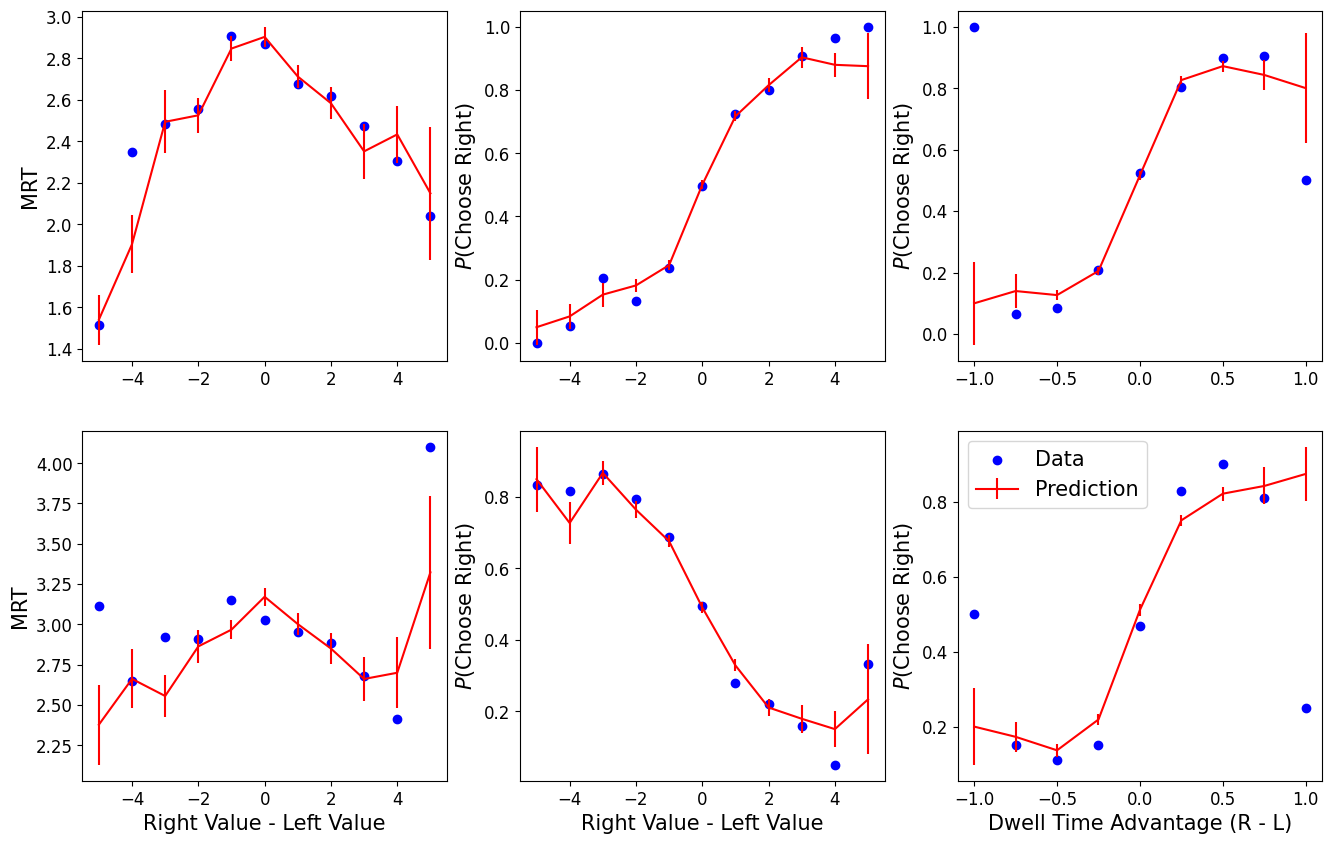

In [13]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.ylabel('MRT');

plt.subplot(232)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(233)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

###########
plt.subplot(234)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(235)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(236)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/sp2020_valuebased_splitted_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

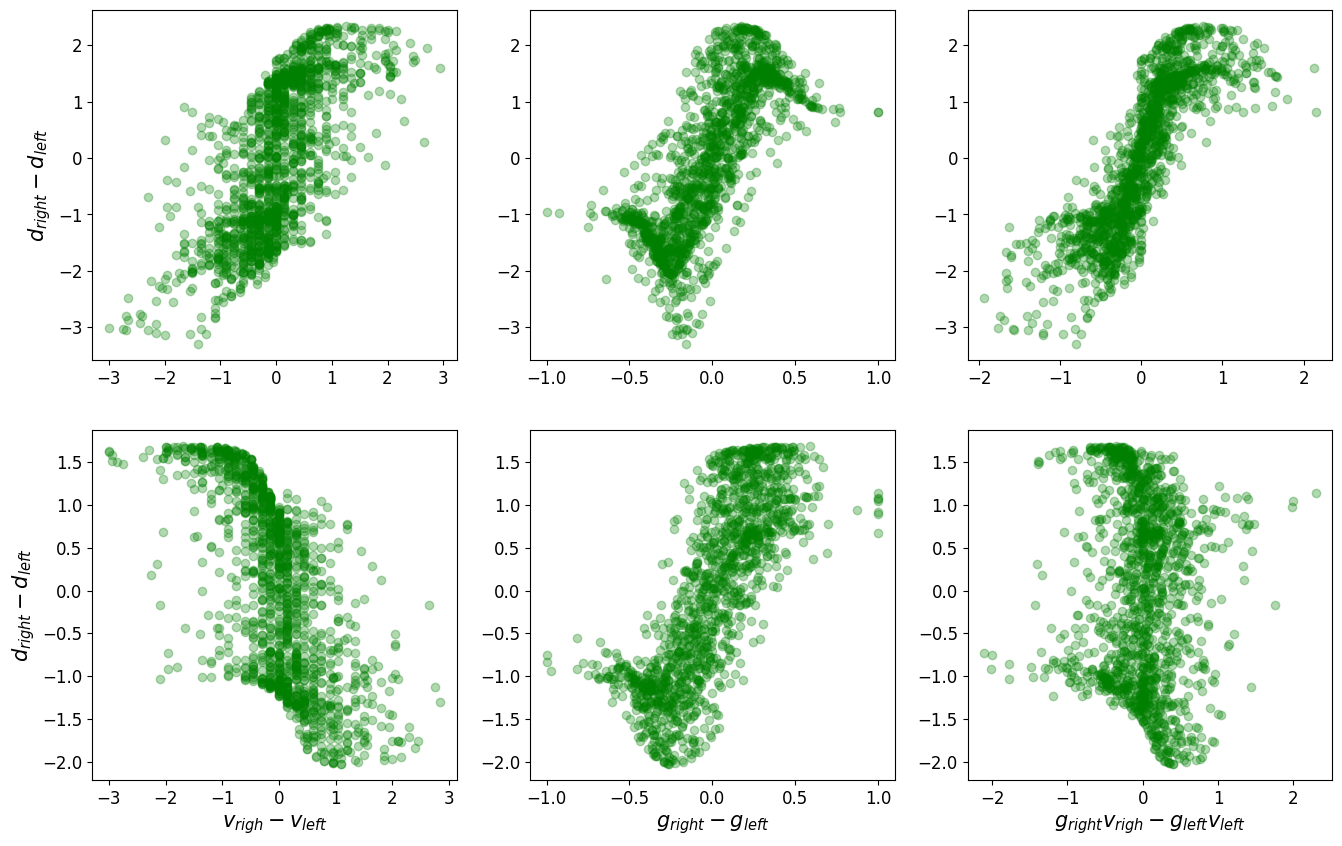

In [14]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_valuebased_splitted_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');